### Importando os Pacotes Utilitários

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Baixando os Conjuntos de Dados do Servidor

In [3]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/CheXpert-v1.0-small.zip', 
                      extract_dir = '/content/CheXpert-v1.0-small', format = 'zip')

In [4]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/vinbigdata.zip', 
                      extract_dir = '/content/vinbigdata/', format = 'zip')

In [5]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/images.zip', 
                      extract_dir = '/content/images/', format = 'zip')

### Organizando e Analisando os Dados

In [6]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset_diseases = dataset[((dataset['Opacity'] == 1.0) | 
                            (dataset['Atelectasis'] == 1.0) | 
                            (dataset['Pneumothorax'] == 1.0) | 
                            (dataset['Effusion'] == 1.0)) & 
                            (dataset['Nodule/Mass'] == 0.0) &
                            (dataset['No Finding'] == 0.0)].copy()

dataset_diseases.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset_diseases.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

dataset_no_diseases = dataset[dataset['No Finding'] == 1.0].copy()

dataset_diseases['Abnormal'] = 1.0
dataset_no_diseases['Abnormal'] = 0.0

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

In [7]:
findings = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion', 'No Finding']
findings_pt = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão', 'Normal']

Text(0, 0.5, 'Imagens')

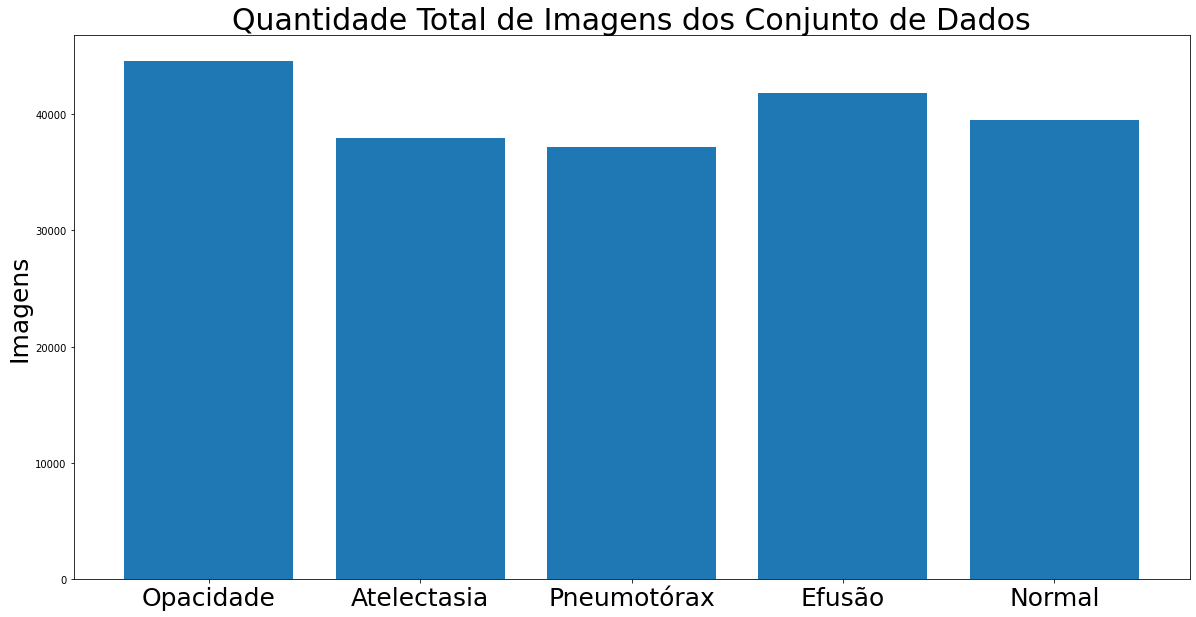

In [8]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [9]:
opacity = np.array(dataset_diseases['Opacity']).astype(str)
atelectasis = np.array(dataset_diseases['Atelectasis']).astype(str)
pneumothorax = np.array(dataset_diseases['Pneumothorax']).astype(str)
effusion = np.array(dataset_diseases['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset_diseases['labels_ref'] = all_labels

In [10]:
_, dataset_diseases = train_test_split(dataset_diseases, test_size = 0.45011, 
                                       random_state = 42, 
                                       stratify = dataset_diseases['labels_ref'])

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

Text(0, 0.5, 'Imagens')

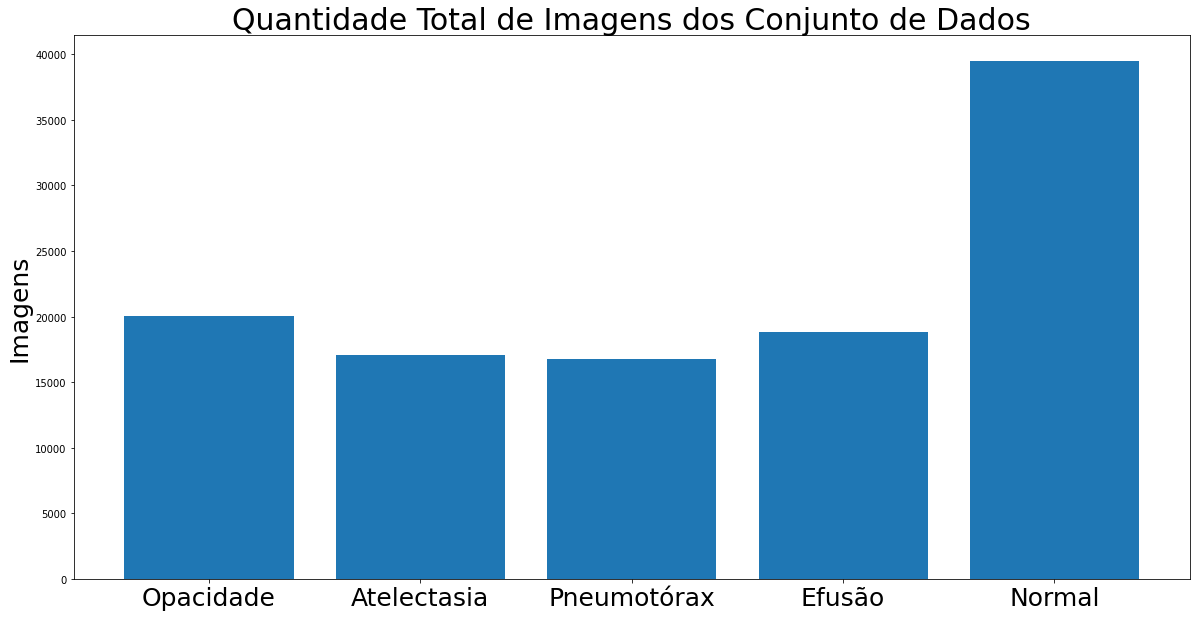

In [11]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

Text(0, 0.5, 'Imagens')

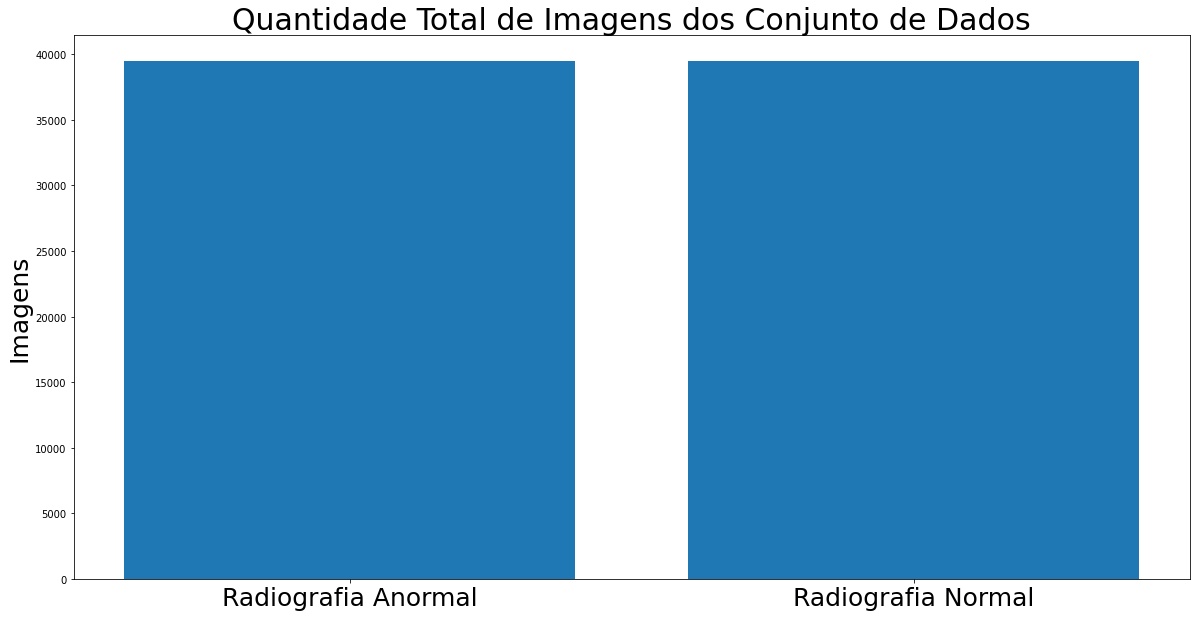

In [12]:
count_findings = list()
count_findings.append(dict(dataset['Abnormal'].value_counts())[1.0])
count_findings.append(dict(dataset['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [13]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['Abnormal'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['Abnormal'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

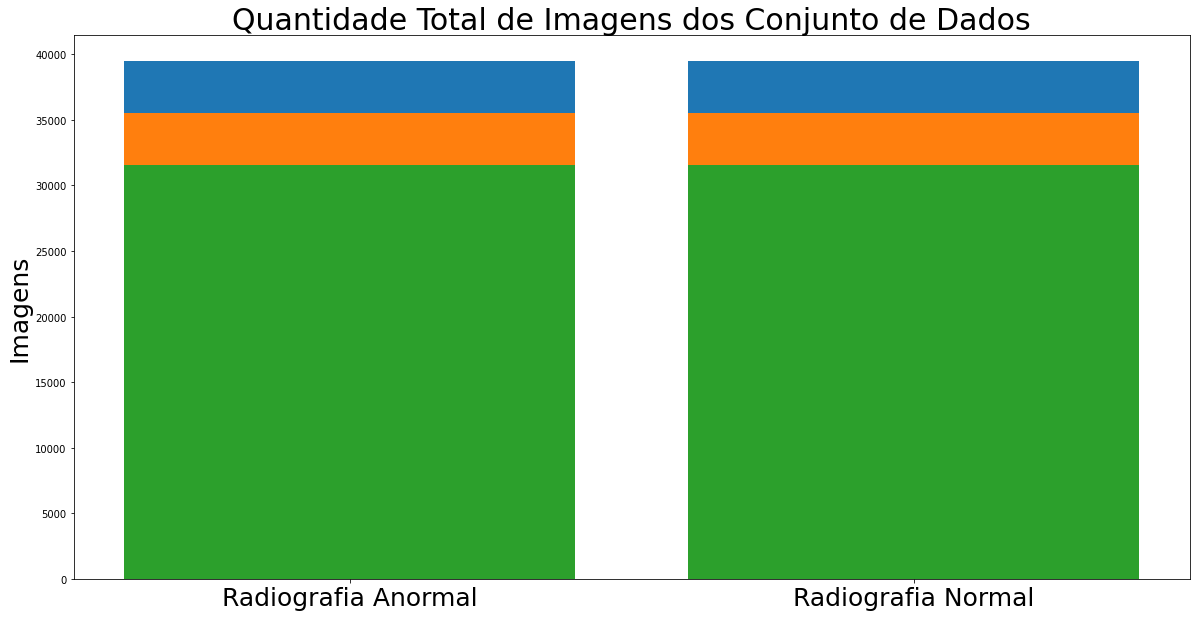

In [14]:
count_train, count_val, count_test = [], [], []
count_train.append(dict(f_train['Abnormal'].value_counts())[1.0])
count_train.append(dict(f_train['Abnormal'].value_counts())[0.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[1.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[0.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[1.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_train)

plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

### Gerador de Imagens do Keras

In [31]:
image_size, batch_size = 224, 64
labels = ['Abnormal']

In [37]:
core_idg1 = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input)
core_idg2 = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
core_idg3 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input)
core_idg4 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
core_idg5 = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input)
core_idg6 = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)

test_gen1 = core_idg1.flow_from_dataframe(dataframe = f_test, directory = None, 
                                          x_col = 'Path', y_col = labels, 
                                          class_mode = 'raw', batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False)

test_gen2 = core_idg2.flow_from_dataframe(dataframe = f_test, directory = None, 
                                          x_col = 'Path', y_col = labels, 
                                          class_mode = 'raw', batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False)

test_gen3 = core_idg3.flow_from_dataframe(dataframe = f_test, directory = None, 
                                          x_col = 'Path', y_col = labels, 
                                          class_mode = 'raw', batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False)

test_gen4 = core_idg4.flow_from_dataframe(dataframe = f_test, directory = None, 
                                          x_col = 'Path', y_col = labels, 
                                          class_mode = 'raw', batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False)

test_gen5 = core_idg5.flow_from_dataframe(dataframe = f_test, directory = None, 
                                          x_col = 'Path', y_col = labels, 
                                          class_mode = 'raw', batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False)

test_gen6 = core_idg6.flow_from_dataframe(dataframe = f_test, directory = None, 
                                          x_col = 'Path', y_col = labels, 
                                          class_mode = 'raw', batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False)

y_labels_test1 = test_gen1.labels
y_labels_test2 = test_gen2.labels
y_labels_test3 = test_gen3.labels
y_labels_test4 = test_gen4.labels
y_labels_test5 = test_gen5.labels
y_labels_test6 = test_gen6.labels

Found 7895 validated image filenames.
Found 7895 validated image filenames.
Found 7895 validated image filenames.
Found 7895 validated image filenames.
Found 7895 validated image filenames.
Found 7895 validated image filenames.


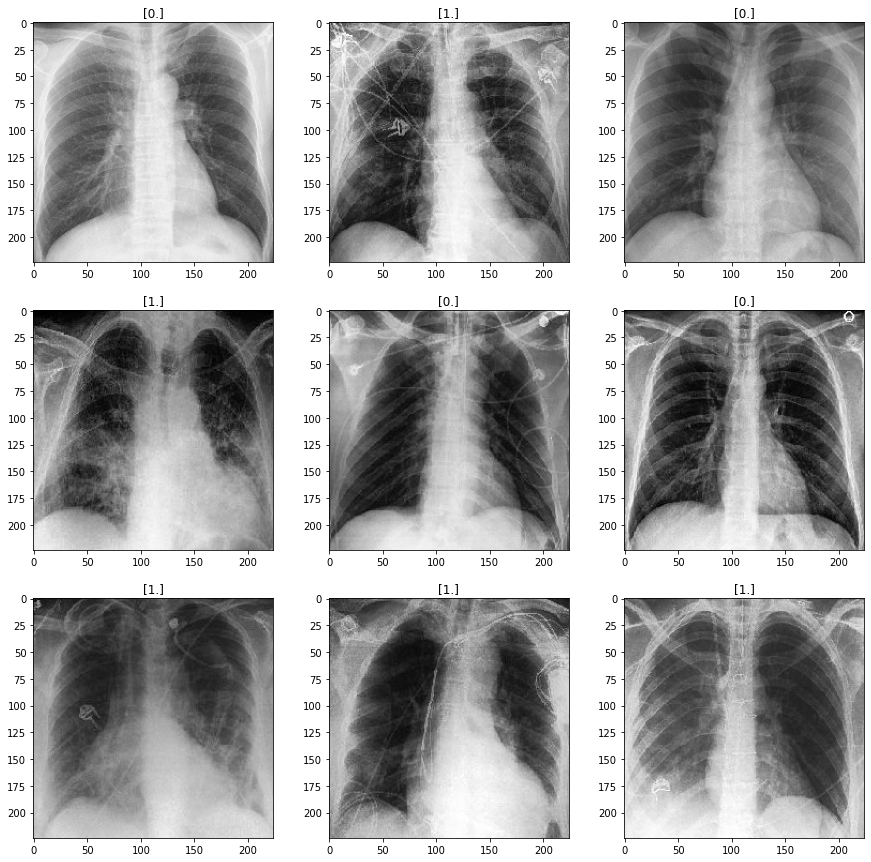

In [35]:
(x,y) = test_gen2[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count] / 255.)
    count +=1

### Definindo uma Função de Binarização das Predições

In [18]:
def binarize_preds(pred_array, column, threshold):
  '''
  função que binariza as predições mutirrótulo do modelo

  Args:
    pred_array (array) --> vetor com as predições multirrótulo
    column (int) --> coluna do vetor multirrótulo a ser analisada
    threshold (float) --> valor de threshold a ser considerado na predição
  
  Returns:
    pred_bin (array) --> vetor de predição com os valores binarizados
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

### Carregando os Modelos Salvos

In [19]:
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/EfficientNetB0/model_efficientnet3.zip /content/EfficientNetB0
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/EfficientNetB0/model.efficientnet.h5 /content/EfficientNetB0
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/DenseNet121/model_densenet3.zip /content/DenseNet121
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/DenseNet121/model.densenet.h5 /content/DenseNet121
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionResNetV2/model_inceptionresnet3.zip /content/InceptionResNetV2
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionResNetV2/model.inceptionresnet.h5 /content/InceptionResNetV2
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionV3/model_inception3.zip /content/InceptionV3
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionV3/model.inception.h5 /content/InceptionV3
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/ResNet101V2/model_resnet3.zip /content/ResNet101V2
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/ResNet101V2/model.resnet.h5 /content/ResNet101V2
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/Xception/model_xception3.zip /content/Xception
!cp /content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/Xception/model.xception.h5 /content/Xception

In [ ]:
!unzip /content/DenseNet121/model_densenet3.zip -d /content/DenseNet121
!unzip /content/EfficientNetB0/model_efficientnet3.zip -d /content/EfficientNetB0
!unzip /content/InceptionResNetV2/model_inceptionresnet3.zip -d /content/InceptionResNetV2
!unzip /content/InceptionV3/model_inception3.zip -d /content/InceptionV3
!unzip /content/ResNet101V2/model_resnet3.zip -d /content/ResNet101V2
!unzip /content/Xception/model_xception3.zip -d /content/Xception

In [22]:
densenet = tf.keras.models.load_model('/content/DenseNet121')
densenet.load_weights('/content/DenseNet121/model.densenet.h5')
efficientnet = tf.keras.models.load_model('/content/EfficientNetB0')
efficientnet.load_weights('/content/EfficientNetB0/model.efficientnet.h5')
inceptionresnet = tf.keras.models.load_model('/content/InceptionResNetV2')
inceptionresnet.load_weights('/content/InceptionResNetV2/model.inceptionresnet.h5')
inception = tf.keras.models.load_model('/content/InceptionV3')
inception.load_weights('/content/InceptionV3/model.inception.h5')
resnet = tf.keras.models.load_model('/content/ResNet101V2')
resnet.load_weights('/content/ResNet101V2/model.resnet.h5')
xception = tf.keras.models.load_model('/content/Xception')
xception.load_weights('/content/Xception/model.xception.h5')

In [36]:
y_pred1 = densenet.predict(test_gen1)
y_pred2 = efficientnet.predict(test_gen2)
y_pred3 = inceptionresnet.predict(test_gen3)
y_pred4 = inception.predict(test_gen4)
y_pred5 = resnet.predict(test_gen5)
y_pred6 = xception.predict(test_gen6)

### Análise Geral da Métrica AUC dos Modelos

In [41]:
y_pred = np.concatenate((y_pred2, y_pred3, y_pred4, y_pred1, y_pred5, y_pred6),
                         axis = 1)
y_labels_test_all = np.concatenate((y_labels_test2, y_labels_test3, y_labels_test4,
                                    y_labels_test1, y_labels_test5, y_labels_test6), 
                                    axis = 1)

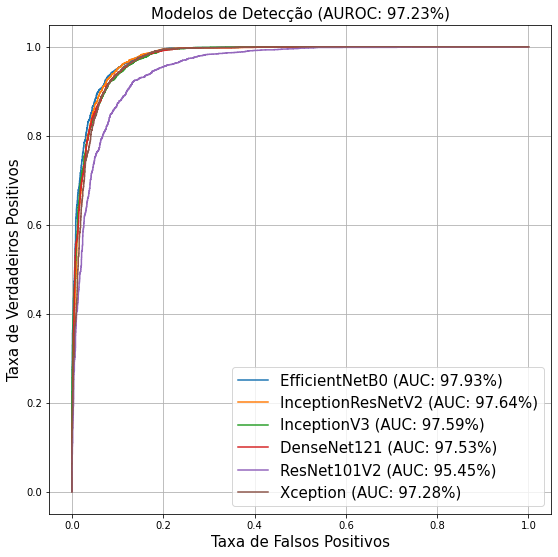

In [42]:
labels_portugues = ['EfficientNetB0', 'InceptionResNetV2', 'InceptionV3', 
                    'DenseNet121', 'ResNet101V2', 'Xception']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test_all[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test_all.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelos de Detecção (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)